In [ ]:
from defog_pipeline import KimDefogPipeline
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

image_dir = Path("/home/nathan/code/class/Digital-Image-Processing/fog-removal/images")
processed_image_dir = Path("/home/nathan/code/class/Digital-Image-Processing/fog-removal/processed_images")
dehazer = KimDefogPipeline()

foggy_images = []
dehazed_images = []
for i, path in enumerate(image_dir.glob("*.png")):
    foggy_img = cv2.imread(path)
    dehazed_img = dehazer.dehaze(foggy_img)
    processed_path = processed_image_dir / f"{path.stem}.png"
    cv2.imwrite(processed_path, dehazed_img)
    foggy_images.append(foggy_img)
    dehazed_images.append(dehazed_img)


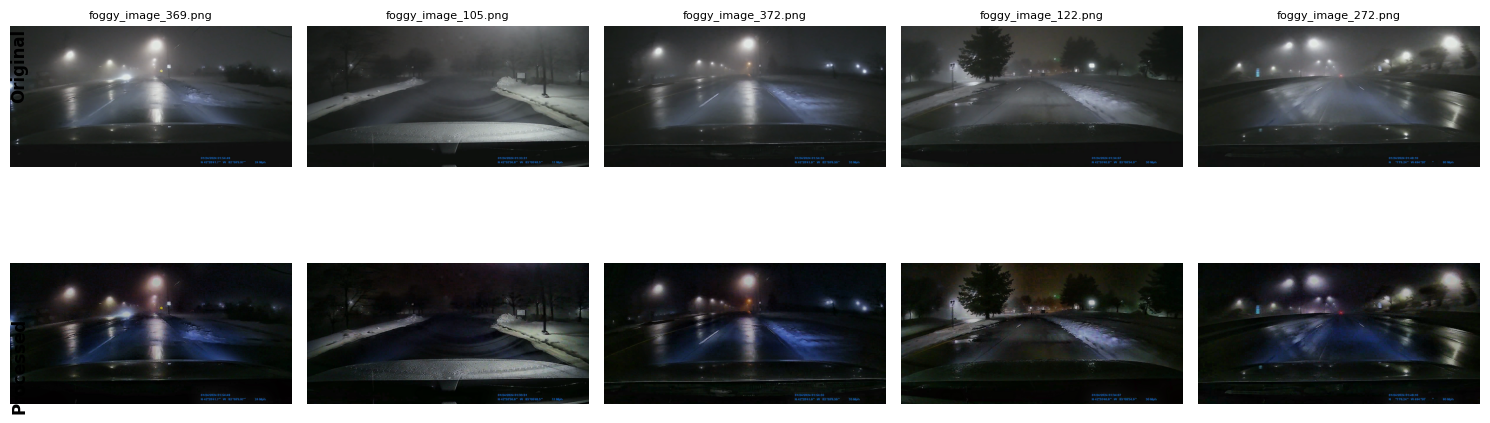

In [31]:
import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image

# --- CONFIGURATION ---
# Define your Path objects
original_dir = Path("images")
processed_dir = Path("processed_images")
# ---------------------

def plot_random_comparison():
    # 1. Get list of all PNGs in the original folder
    all_images = list(original_dir.glob("*.png"))
    
    # Safety check: Ensure we have at least 5 images
    if len(all_images) < 5:
        print(f"Not enough images found! Found {len(all_images)}, need 5.")
        return

    # 2. Randomly select 5 files
    selected_files = random.sample(all_images, 5)

    # 3. Setup the grid (2 Rows, 5 Columns)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    
    # Add overall titles to the rows (optional, but looks nice)
    fig.text(0.01, 0.75, 'Original', va='center', rotation='vertical', fontsize=12, fontweight='bold')
    fig.text(0.01, 0.25, 'Processed', va='center', rotation='vertical', fontsize=12, fontweight='bold')

    for i, original_path in enumerate(selected_files):
        filename = original_path.name
        
        # Construct path to the matching processed image
        # (processed_dir / filename) joins the path smartly
        processed_path = processed_dir / filename

        # --- Plot Top Row (Original) ---
        ax_top = axes[0, i]
        if original_path.exists():
            img = Image.open(original_path)
            ax_top.imshow(img)
            ax_top.set_title(filename, fontsize=8)
        else:
            ax_top.text(0.5, 0.5, "Missing", ha='center')
        ax_top.axis('off')

        # --- Plot Bottom Row (Processed) ---
        ax_bot = axes[1, i]
        if processed_path.exists():
            img_proc = Image.open(processed_path)
            ax_bot.imshow(img_proc)
        else:
            # Handle case where processed version doesn't exist
            ax_bot.text(0.5, 0.5, "Not Found", ha='center')
        ax_bot.axis('off')

    plt.tight_layout()
    plt.show()


plot_random_comparison()

Get rid of similar images

In [26]:
import os
import glob
import imagehash
from PIL import Image
from tqdm import tqdm

# --- CONFIGURATION ---
IMAGE_DIR = "./images"
LABEL_DIR = "./images/auto_labels_bdd" # Optional: Delete the label too if it exists
# Threshold: Lower = stricter (0 means identical only). 
# 5 is usually good for "visually the same but slightly different fog/noise"
CUTOFF = 5 
# ---------------------

def remove_duplicates():
    # Check if imagehash is installed
    try:
        import imagehash
    except ImportError:
        print("Please run: pip install imagehash")
        return

    image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.png")))
    print(f"Scanning {len(image_paths)} images for duplicates...")

    # Dictionary to store the hash of the images we decide to KEEP
    # Format: { hash_object: "filename" }
    kept_hashes = {} 
    deleted_count = 0

    for img_path in tqdm(image_paths):
        try:
            img = Image.open(img_path)
            
            # Calculate the "Average Hash" (Fast and effective for structure)
            img_hash = imagehash.average_hash(img)
            
            is_duplicate = False
            
            # Compare with all kept hashes
            # Note: For massive datasets (10k+), this part can be optimized. 
            # For a few hundred/thousand, a simple loop is fast enough.
            for existing_hash in kept_hashes:
                # Calculate difference (Hamming distance)
                if img_hash - existing_hash < CUTOFF:
                    is_duplicate = True
                    break
            
            if is_duplicate:
                # DELETE THE IMAGE
                os.remove(img_path)
                deleted_count += 1
                
                # OPTIONAL: Delete the corresponding label mask if you made one
                basename = os.path.basename(img_path)
                mask_path = os.path.join(LABEL_DIR, basename)
                if os.path.exists(mask_path):
                    os.remove(mask_path)
            else:
                # Keep this image
                kept_hashes[img_hash] = img_path
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print(f"Done! Deleted {deleted_count} duplicate images.")

if __name__ == "__main__":
    remove_duplicates()

Scanning 427 images for duplicates...


100%|██████████| 427/427 [00:03<00:00, 110.32it/s]

Done! Deleted 0 duplicate images.


Rename images

In [27]:
import os
import glob
import re

# --- CONFIGURATION ---
IMG_DIR = "./images"
LBL_DIR = "./images/auto_labels_bdd"
# ---------------------

def numerical_sort(value):
    """
    Helper to sort filenames like humans do (1, 2, 10) instead of computers (1, 10, 2).
    Extracts the numbers from the filename string.
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def renumber_dataset():
    print("Renumbering dataset to fill gaps...")
    
    # 1. Get all PNGs and sort them numerically
    # We verify they exist in the Image directory
    images = glob.glob(os.path.join(IMG_DIR, "*.png"))
    images.sort(key=numerical_sort)
    
    if not images:
        print("No images found to renumber.")
        return

    # 2. Rename to a temporary format first
    # This prevents conflicts (e.g. renaming "image_5" to "image_4" while "image_4" still exists)
    temp_map = []
    print("Phase 1: Safe rename to temporary names...")
    for i, img_path in enumerate(images):
        directory, filename = os.path.split(img_path)
        
        # Generate Temp Name
        temp_name = f"temp_renumbering_{i}.png"
        temp_path = os.path.join(directory, temp_name)
        
        os.rename(img_path, temp_path)
        
        # Handle the corresponding Label file if it exists
        # We assume label has same basename as image
        mask_path = os.path.join(LBL_DIR, filename)
        temp_mask_path = None
        
        if os.path.exists(mask_path):
            temp_mask_name = f"temp_renumbering_{i}.png"
            temp_mask_path = os.path.join(LBL_DIR, temp_mask_name)
            os.rename(mask_path, temp_mask_path)
            
        # Store the mapping for Phase 2
        temp_map.append((temp_path, temp_mask_path))

    # 3. Rename to final sequential format
    print("Phase 2: Rename to final sequential format...")
    for i, (temp_img, temp_mask) in enumerate(temp_map):
        # Define final name
        final_name = f"foggy_image_{i}.png"
        
        # Rename Image
        final_img_path = os.path.join(IMG_DIR, final_name)
        os.rename(temp_img, final_img_path)
        
        # Rename Mask (if it existed)
        if temp_mask:
            final_mask_path = os.path.join(LBL_DIR, final_name)
            os.rename(temp_mask, final_mask_path)

    print(f"Success! Renumbered {len(images)} images from 0 to {len(images)-1}.")

if __name__ == "__main__":
    # You can run your dedup first, then this:
    # remove_duplicates() 
    renumber_dataset()

Renumbering dataset to fill gaps...
Phase 1: Safe rename to temporary names...
Phase 2: Rename to final sequential format...
Success! Renumbered 427 images from 0 to 426.
